# V - Supervised Subsampling with CAFI data
### Run a supervised classification based on validated data from CAFI DDD for training, and subsample by KMeans-Neyman stratification
##### This script estimates a probability of forest change based on eSBAE variables, using CAFI validated data (2015-2020) as training. 
##### The change probability is then divided into 3 strata, which are proportionally sampled for validation
##### You can export samples as csv to create your own CEO project
##### This script requires an m16 or r16 instance to run
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling


import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.8/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


# 1 - CEO data preparation

## 1.1 - Import CEO interpreted data
Import the CEO validated data from CAFI DDD first phase

### 13,115 points, randomly distributed over CAFI, with interpretation

In [2]:
# this file is available here: https://drive.google.com/file/d/1D1tkVVhKv6QNCQhLLfRo7eqz0VO3XZZF/view?usp=sharing
# unzip and upload to your SEPAL workspace using Filezilla
trn_ceo = pd.read_csv('/home/sepal-user/CAFI_DDD/all_ceo_validation_TMF_2023_uniqueID.csv', delimiter=',')
#trn_ceo = pd.read_csv('/home/sepal-user/data/validation/all_ceo_validation.csv', delimiter=',')
trn_ceo.head()

,OID_,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Co,Ref_FNF,Ref_LCover,Ref_Change,...,Ref_IndAg,Ref_ArtFor,Ref_IndFor,Ref_ArtMin,Ref_IndMin,Ref_Other,Source,Ref_ChDate,Change_Bin,UniqueID
0,0,311,NaN,25.602120,-11.691888,COD,147,1,11,Deg,...,0,1,0,0,0,0,ceo,Deg_2018,1,1
1,1,53,NaN,19.012978,6.404943,CAF,149,1,11,Deg,...,0,1,0,0,0,0,ceo,Deg_2020,1,2
2,2,47,NaN,22.791831,7.078410,CAF,149,1,11,Deg,...,0,1,0,0,0,0,ceo,Deg_2020,1,3
3,3,279,NaN,27.430102,-6.534839,COD,11,1,11,Stable,...,0,0,0,0,0,0,ceo,Stable,0,4
4,4,224,NaN,22.212148,-9.940982,COD,11,1,11,Stable,...,0,0,0,0,0,0,ceo,Stable,0,5


## Load the corresponding augmented data set into a GDF

In [3]:
# this geojson file can be downloaded here: https://drive.google.com/file/d/1fEDJSnHVR8AqmqPKbeOvVtRGvrdieYwm/view?usp=sharing
# unzip and upload to your SEPAL workspace using FileZilla
trn_gdf = py_helpers.geojson_to_gdf('/home/sepal-user/module_results/esbae/CAFI_esbae.geojson')
trn_gdf.columns

Index(['geometry', 'UniqueID', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude',
       'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri

In [4]:
cols_to_export = ['geometry', 'UniqueID',
                  #'dates', 'ts',
                  'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude',
       'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope', 'tmf_2016',
       'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear',
       'tmf_degyear', 'tmf_main', 'tmf_sub']

Export all ebsae points as CSV (optional)

In [ ]:
#csv_out_file =  '/home/sepal-user/module_results/esbae/export_CAFI_esbae.csv'
#trn_gdf[cols_to_export].to_csv(csv_out_file)

In [5]:
len(trn_gdf.index)

13115

In [6]:
len(trn_ceo.index)

13115

In [7]:
trn_gdf = trn_gdf[cols_to_export]

### 1.2 - Inspect CEO interpreted data

Our ultimate goal is to use the CEO data for getting the probability of forest change via a series of classifications and their probability output. . , i.e. Forest-Non-Forest and a Change-No-Change classifcation.
Therefore we need to extract and trnasform the relevant information into a column of 0s and 1s. 

First let's look at the columns the CEO file contains.

In [8]:
trn_ceo.columns

Index(['OID_', 'PLOTID', 'CEO_PLOTID', 'LON', 'LAT', 'ISO', 'CEO_Ref_Co',
       'Ref_FNF', 'Ref_LCover', 'Ref_Change', 'Ref_Chan_1', 'countDrive',
       'Ref_InfraR', 'Ref_Urb', 'Ref_ArtAg', 'Ref_IndAg', 'Ref_ArtFor',
       'Ref_IndFor', 'Ref_ArtMin', 'Ref_IndMin', 'Ref_Other', 'Source',
       'Ref_ChDate', 'Change_Bin', 'UniqueID'],
      dtype='object')

In [9]:
#print(trn_ceo.duplicated(subset=['UniqueID']).value_counts())

In [10]:
trn_ceo['UniqueID'].nunique(dropna=False)

13115

In [11]:
#trn_gdf.columns

In [12]:
trn_gdf['UniqueID'].nunique(dropna=False)

13115

### 1.3 Print unique values for columns of interest generate Change-No Change

In [13]:
# show unique values for the columns (in red)
print('Change', trn_ceo['Ref_Change'].unique())

Change ['Deg' 'Stable' 'NF' 'Def']


In [14]:
# add CNC column for classification
trn_ceo['cnc_1520'] = trn_ceo['Ref_Change'].apply(lambda x: 1 if x == 'Def' or x == 'Deg'  else 0)


#trn_join.head(5)
np.unique(trn_ceo['cnc_1520'], return_counts=True)

(array([0, 1]), array([9275, 3840]))

In [15]:
trn_join = pd.merge(trn_ceo,trn_gdf, left_on='UniqueID', right_on='UniqueID',how='outer')
len(trn_join.index)

13115

# 2 - Join CEO and Time-Series data

### 2.1 - Load data augmented time-series data from script 4
#### your area must intersect with the CAFI region

In [16]:
# glob all files in the data augmentation output folder
files = Path('/home/sepal-user/module_results/esbae/COG/04_Data_Augmentation/Landsat/').glob('*geojson')

# prepare for parallel execution
files = [[str(file), False] for file in files]

# read files in parallel nad put the in a list
result = py_helpers.run_in_parallel(
    py_helpers.geojson_to_gdf,
    files,
    workers=4,
    parallelization='processes'
)

# concatenate dataframes from result's list
cdf = pd.concat(result)

In [17]:
len(cdf.index)

291595

In [18]:
print(cdf.columns)

Index(['geometry', 'point_id', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'a

In [19]:
print(trn_gdf.columns)

Index(['geometry', 'UniqueID', 'images', 'mon_images', 'bfast_change_date',
       'bfast_magnitude', 'bfast_means', 'cusum_change_date',
       'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min',
       'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean',
       'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd',
       'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min',
       'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min',
       'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min',
       'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min',
       'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max',
       'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_l

In [20]:
print(trn_ceo.columns)

Index(['OID_', 'PLOTID', 'CEO_PLOTID', 'LON', 'LAT', 'ISO', 'CEO_Ref_Co',
       'Ref_FNF', 'Ref_LCover', 'Ref_Change', 'Ref_Chan_1', 'countDrive',
       'Ref_InfraR', 'Ref_Urb', 'Ref_ArtAg', 'Ref_IndAg', 'Ref_ArtFor',
       'Ref_IndFor', 'Ref_ArtMin', 'Ref_IndMin', 'Ref_Other', 'Source',
       'Ref_ChDate', 'Change_Bin', 'UniqueID', 'cnc_1520'],
      dtype='object')


#### not working at the moment
#### you coulc export the csv file the first time, and then next time you run the script, just read it and skip to section 2.1a or 2.2 

In [ ]:
#csv_out_file =  '/home/sepal-user/module_results/esbae/GAB/GAB_esbae_data_augmented.csv'
#trn_gdf[cols_to_export].to_csv(csv_out_file)

In [ ]:
#cdf = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_data_augmented.csv', delimiter=',')

### 2.1a - drop points which aren't within the forest mask (optional)
##### this is a an optional step to focus validation in areas we are certain were forest in 2000, therefore reducing the need to validate non-forest areas, including water.

In [21]:
#this file can be downloaded here: https://drive.google.com/file/d/1SGNJM7uwGhEgSrW530aVW6jKbuyW1pC9/view?usp=sharing
#unzip it and upload to your SEPAL workspace using Filezilla
src = rasterio.open("/home/sepal-user/data/lc_map/forest_mask.tif")

In [22]:
coord_list = [(x, y) for x, y in zip(cdf["geometry"].x, cdf["geometry"].y)]

In [23]:
cdf["value"] = [x for x in src.sample(coord_list)]
cdf['value'] = cdf['value'].str[0]
cdf.head()

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,value
0,POINT (13.26137 -2.38401),715747,"[20110417, 20110908, 20130508, 20140409, 20140...","{'green': [325.0, 642.0, 797.0, 386.0, 391.0, ...",42,36,-1.000,0.000000,0.000000,2017.227,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,1
1,POINT (13.27132 -2.38402),715821,"[20120809, 20121028, 20130508, 20130516, 20131...","{'green': [398.0, 793.0, 536.0, 507.0, 1505.0,...",37,29,-1.000,0.000000,0.000000,2016.463,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,1
2,POINT (13.28128 -2.38403),715892,"[20110503, 20120809, 20130217, 20130516, 20131...","{'green': [1059.0, 443.0, 413.0, 458.0, 466.0,...",38,31,-1.000,0.000000,0.000000,2022.156,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,1
3,POINT (13.16836 -2.75961),716313,"[20100124, 20121028, 20130217, 20130516, 20140...","{'green': [388.0, 1170.0, 371.0, 309.0, 730.0,...",33,25,-1.000,0.000000,0.000000,2015.126,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,1
4,POINT (13.19825 -2.75963),716436,"[20100124, 20110417, 20110503, 20130217, 20130...","{'green': [389.0, 281.0, 304.0, 349.0, 493.0, ...",33,24,2022.441,-86.595612,-37407.789062,2015.126,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,1


In [24]:
select = cdf.loc[cdf['value'] == 1]

In [25]:
len(select.index)

214811

In [26]:
select.drop(columns=['value'])

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,tmf_2015,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub
0,POINT (13.26137 -2.38401),715747,"[20110417, 20110908, 20130508, 20140409, 20140...","{'green': [325.0, 642.0, 797.0, 386.0, 391.0, ...",42,36,-1.000,0.000000,0.000000,2017.227,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.00,10.0,10.0
1,POINT (13.27132 -2.38402),715821,"[20120809, 20121028, 20130508, 20130516, 20131...","{'green': [398.0, 793.0, 536.0, 507.0, 1505.0,...",37,29,-1.000,0.000000,0.000000,2016.463,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.00,10.0,10.0
2,POINT (13.28128 -2.38403),715892,"[20110503, 20120809, 20130217, 20130516, 20131...","{'green': [1059.0, 443.0, 413.0, 458.0, 466.0,...",38,31,-1.000,0.000000,0.000000,2022.156,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.00,10.0,10.0
3,POINT (13.16836 -2.75961),716313,"[20100124, 20121028, 20130217, 20130516, 20140...","{'green': [388.0, 1170.0, 371.0, 309.0, 730.0,...",33,25,-1.000,0.000000,0.000000,2015.126,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.00,10.0,10.0
4,POINT (13.19825 -2.75963),716436,"[20100124, 20110417, 20110503, 20130217, 20130...","{'green': [389.0, 281.0, 304.0, 349.0, 493.0, ...",33,24,2022.441,-86.595612,-37407.789062,2015.126,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.00,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24991,POINT (15.57888 -0.48382),967098,"[20100218, 20100610, 20101203, 20101219, 20110...","{'green': [476.0, 415.0, 735.0, 606.0, 367.0, ...",153,116,2018.216,99.938408,1.087082,2021.479,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.00,10.0,10.0
24992,POINT (15.58376 -0.47414),967099,"[20100218, 20100610, 20101016, 20101219, 20110...","{'green': [504.0, 442.0, 388.0, 502.0, 638.5, ...",167,125,2015.962,-201.602585,-2.767932,2017.186,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.00,10.0,10.0
24993,POINT (15.58865 -0.46447),967100,"[20100218, 20101016, 20101219, 20110613, 20110...","{'green': [729.5, 348.0, 475.0, 415.0, 625.5, ...",158,119,2015.808,-696.276550,-5.936163,2018.984,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.00,10.0,10.0
24994,POINT (15.59353 -0.45480),967101,"[20100218, 20100610, 20101016, 20101219, 20110...","{'green': [568.5, 544.0, 393.0, 587.0, 710.0, ...",160,124,2016.948,575.789551,1.246832,2022.685,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,503.00,13.0,13.0


In [27]:
cdf = select
len(cdf.index)

214811

In [28]:
print(cdf.columns)

Index(['geometry', 'point_id', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'a

### 2.2 - Make a union with training data

In [29]:
eSBAE_cols = [
    #'geometry', 
    #'point_id', 
    #'dates', 'ts', 
    'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude',
       'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope', 'tmf_2016',
       'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear',
       'tmf_degyear', 'tmf_main', 'tmf_sub']

In [30]:
harm_cols = eSBAE_cols + ['geometry','point_id','cnc_1520']
#cols_to_harmonize

In [31]:
#cdf['UniqueID'] = 0
cdf['cnc_1520'] = float('nan')
trn_join['point_id']= 0

db = pd.concat([cdf[harm_cols],trn_join[harm_cols]])

In [32]:
len(db.index)

227926

In [33]:
trn_join.head(2)

,OID_,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Co,Ref_FNF,Ref_LCover,Ref_Change,...,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,point_id
0,0,311,NaN,25.602120,-11.691888,COD,147,1,11,Deg,...,6.0,6.0,6.0,6.0,6.0,0.0,0.0,70.0,91.0,0
1,1,53,NaN,19.012978,6.404943,CAF,149,1,11,Deg,...,6.0,6.0,6.0,6.0,6.0,0.0,0.0,70.0,91.0,0


In [34]:
db.columns

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max',
       'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd',
       'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min',
       'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max',
       'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max',
       'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
       'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode',
       'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev',
       'dw_tree_prob_mean', 'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17',
       'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 'gfc_

In [35]:
len(cdf.index)+len(trn_join.index) == len(db.index)

True

### 2.3 Check the amount of ground truth data we have for each class

In [36]:
np.unique(db['cnc_1520'], return_counts=True)

(array([ 0.,  1., nan]), array([  9275,   3840, 214811]))

### Run change/no-change classification

In [37]:
# predictors used change/nochange classification
db['chg_prob'] = clf.binary_probability_classification(db, 'cnc_1520', eSBAE_cols, outlier=False)

OOB Score is 0.7886389630194434


In [38]:
clf_db = db[db["point_id"] > 0]

#### plot the change probability
##### a good model will have many points with low probability of change, and then very few points with higher probabilites

array([<Axes: title={'center': 'chg_prob'}>], dtype=object)

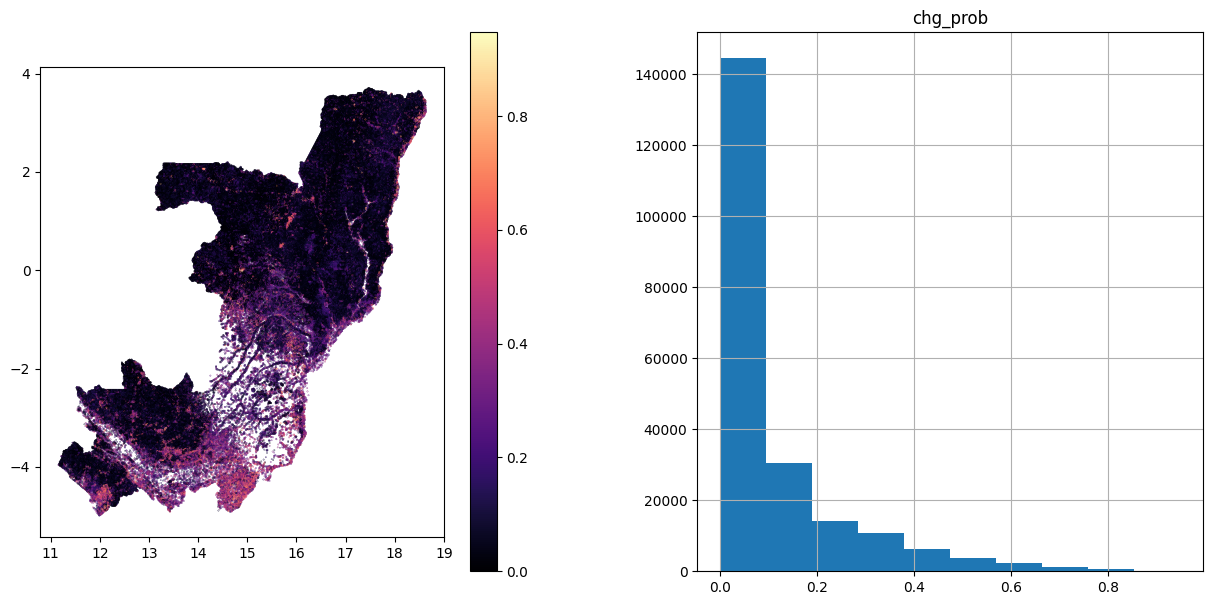

In [39]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('chg_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('chg_prob', ax=ax[1])

In [40]:
clf_db.columns

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max',
       'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd',
       'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min',
       'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max',
       'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max',
       'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
       'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode',
       'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev',
       'dw_tree_prob_mean', 'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17',
       'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 'gfc_

In [41]:
joined_df = clf_db

### Combine probs from Change and Forest

In [42]:
joined_df['simple_combined'] = joined_df['chg_prob']

In [43]:
len(joined_df)

214811

In [44]:
joined_df

,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,...,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,geometry,point_id,cnc_1520,chg_prob,simple_combined
0,42,36,-1.000,0.000000,0.000000,2017.227,0.406504,6411.263889,9395.615741,585.726951,...,1.0,0.0,0.00,10.0,10.0,POINT (13.26137 -2.38401),715747,NaN,0.127333,0.127333
1,37,29,-1.000,0.000000,0.000000,2016.463,0.071684,11975.580460,8627.408046,1889.561833,...,1.0,0.0,0.00,10.0,10.0,POINT (13.27132 -2.38402),715821,NaN,0.080000,0.080000
2,38,31,-1.000,0.000000,0.000000,2022.156,0.018673,2743.026882,9353.940860,445.696570,...,1.0,0.0,0.00,10.0,10.0,POINT (13.28128 -2.38403),715892,NaN,0.046667,0.046667
3,33,25,-1.000,0.000000,0.000000,2015.126,0.247794,4141.013333,9478.193333,589.716376,...,1.0,0.0,0.00,10.0,10.0,POINT (13.16836 -2.75961),716313,NaN,0.066000,0.066000
4,33,24,2022.441,-86.595612,-37407.789062,2015.126,-0.032148,1787.555556,9692.722222,369.445141,...,1.0,0.0,0.00,10.0,10.0,POINT (13.19825 -2.75963),716436,NaN,0.046000,0.046000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24991,153,116,2018.216,99.938408,1.087082,2021.479,0.457500,3826.637315,9851.259154,171.705372,...,1.0,0.0,0.00,10.0,10.0,POINT (15.57888 -0.48382),967098,NaN,0.102000,0.102000
24992,167,125,2015.962,-201.602585,-2.767932,2017.186,0.468007,6743.803600,9777.448343,283.934279,...,1.0,0.0,0.00,10.0,10.0,POINT (15.58376 -0.47414),967099,NaN,0.054667,0.054667
24993,158,119,2015.808,-696.276550,-5.936163,2018.984,0.638840,27091.107403,9208.060044,778.127028,...,1.0,0.0,0.00,10.0,10.0,POINT (15.58865 -0.46447),967100,NaN,0.412667,0.412667
24994,160,124,2016.948,575.789551,1.246832,2022.685,0.336900,9150.644009,9402.120584,468.204803,...,1.0,0.0,503.00,13.0,13.0,POINT (15.59353 -0.45480),967101,NaN,0.170667,0.170667


### Stratify with Kmeans

### select the number of points to sample

In [45]:
sample_size_no = 10000

In [46]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'chg_prob', strata=3, sample_size=sample_size_no)

In [47]:
joined_df['kmeans'] = joined_df['stratum']

,Nh,mean,SD,div,stratum,neyman,proportional
0,164218,0.046048,0.034594,5680.959466,1,5718,7644
1,36783,0.245548,0.070826,2605.189775,2,2622,1712
2,13810,0.536310,0.119375,1648.567598,3,1659,642


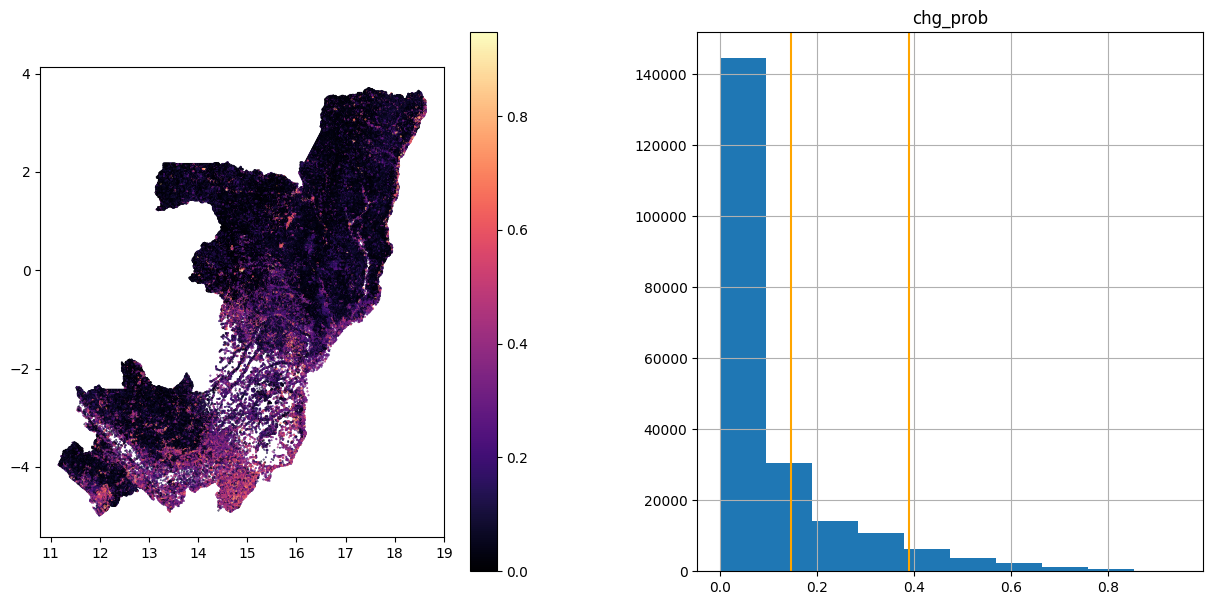

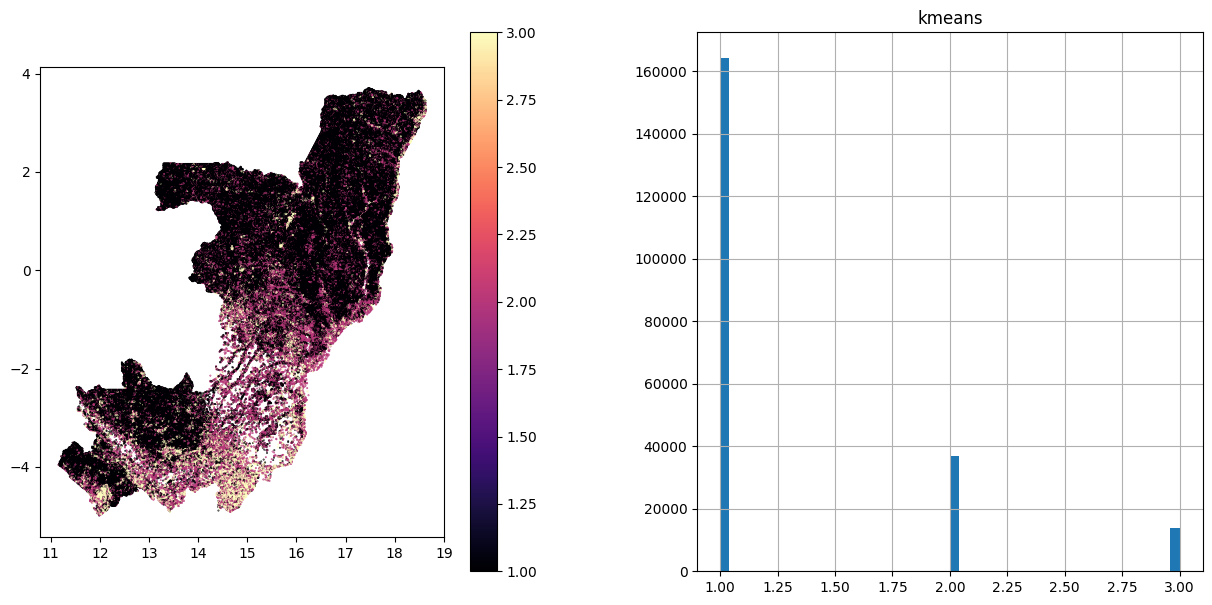

In [48]:
h.plot_cluster(joined_df, prob_column='chg_prob', strata_column='kmeans')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans', ax=ax[1], bins=50)
samples

### align column names, get coordinates


In [49]:
joined_df['PLOTID'] = joined_df['point_id']

In [50]:
joined_df.columns

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max',
       'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd',
       'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min',
       'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max',
       'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max',
       'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
       'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode',
       'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev',
       'dw_tree_prob_mean', 'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17',
       'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 'gfc_

In [51]:
joined_df['LON'] = joined_df.geometry.apply(lambda p: p.x)
joined_df['LAT'] = joined_df.geometry.apply(lambda p: p.y)

#### export the points for your area with the change probability model

In [52]:
all_points_out_file =  '/home/sepal-user/module_results/esbae/COG/COG_esbae_2015_2022_model.csv'
joined_df.to_csv(all_points_out_file,index=False)

### now you may proceed to script 5b if you want to extract sample points for CEO